<a href="https://colab.research.google.com/github/kimyooonkyoung/handsonml2/blob/main/04_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 배치 경사 하강법을 사용한 선형 회귀

그림 저장: generated_data_plot


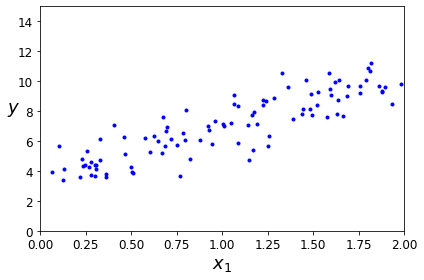

In [6]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [12]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가합니다.

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
                
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [16]:
print(theta)
print(X_new)
print(X_new_b)

[[ 0.49671415]
 [-0.1382643 ]]
[[0]
 [2]]
[[1. 0.]
 [1. 2.]]


In [18]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):

        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        
        if theta_path is not None:
            theta_path.append(theta)
    
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

그림 저장: gradient_descent_plot


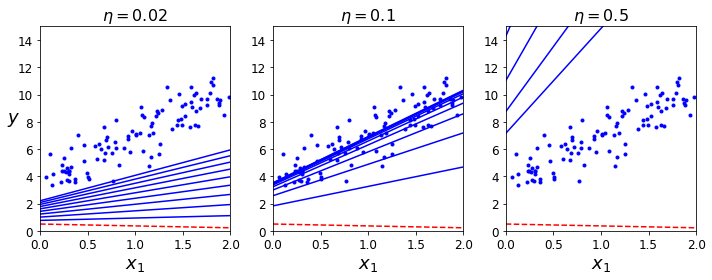

In [19]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

# learning rate (eta) 를 변화시켜가면서 그래프로 확인
plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02) # 너무 작음
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd) # 적당
plt.subplot(133); plot_gradient_descent(theta, eta=0.5) # 너무 큼

save_fig("gradient_descent_plot")
plt.show()


## 확률적 경사 하강법 (SGD)
배치 경사하강법은 모든 샘플데이터 m 개를 다 돌고, 한번 이동하지만
SGD 는 m 개의 샘플 중 랜덤으로 1개를 계산하고, 이동한다.

In [33]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

그림 저장: sgd_plot


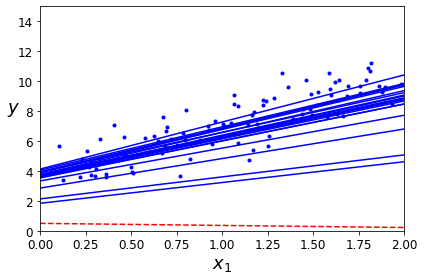

In [34]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):

        # 그림으로 표현
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = 'b-' if i > 0 else 'r--'
            plt.plot(X_new, y_predict, style)

        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]

        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, 'b.')
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
save_fig("sgd_plot")                                 
plt.show()   

# 배치하강법보다 gradient 가 불규칙적으로 내려가는걸 확인할 수 있음

In [28]:
theta

array([[3.54328332],
       [3.35780701]])

## 미니배치 경사하강법

In [29]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2, 1) # weight

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)

    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]

    for i in range(0, m, minibatch_size):
        t += 1

        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]

        gradients = 2 / minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [30]:
theta

array([[3.51390218],
       [3.30426969]])

In [36]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

그림 저장: gradient_descent_paths_plot


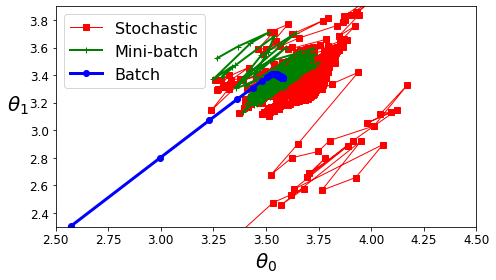

In [37]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

In [ ]:
theta_path_mgd

## 4.7 연습문제 12번

In [39]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [40]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [41]:
X = iris['data'][:, (2,3)] # 꽃잎 길이, 꽃잎 넓이
y = iris['target']

In [43]:
X_with_bias = np.c_[np.ones([len(X), 1]), X] # X 에 1 더함 (bias 추가)

In [44]:
np.random.seed(2042)

In [46]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

In [47]:
def to_one_hot(y):
    n_classes = y.max() + 1

    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1

    return Y_one_hot

In [48]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [49]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [51]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [52]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)

    return exps / exp_sums

In [53]:
n_inputs = X_train.shape[1]  # bias + feature num (꽃잎 길이 + 꽃잎 너비)
n_outputs = len(np.unique(y_train)) # class num

In [55]:
lr = 0.01 # learning rate
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

# weight random initialize
Weight = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Weight)
    output = softmax(logits) # 확률값 계산
    
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(output + epsilon), axis=1))
    error = output - Y_train_one_hot
    
    if iteration % 500 == 0:
        print(iteration, loss)

    gradients = 1/m * X_train.T.dot(error)
    Weight = Weight - lr * gradients

0 6.101695333134016
500 0.7495955964003087
1000 0.6335867601044719
1500 0.5627809964824694
2000 0.5154218410707394
2500 0.48116101400112515
3000 0.45483325048430245
3500 0.4336617868483096
4000 0.4160434121580319
4500 0.40099310107809877
5000 0.38787288168306755


In [56]:
Weight

array([[ 3.68653944,  0.10079783, -1.99541063],
       [ 0.33885719,  1.11266289,  0.75252074],
       [-0.85514954,  1.11918494,  3.57304747]])

In [58]:
logits = X_valid.dot(Weight)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

In [59]:

eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:])) # Theta 의 첫번째는 bias 이므로 l2loss 적용안함
    
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    
    if iteration % 500 == 0:
        print(iteration, loss)
    
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 5.401014020496038
500 0.5399802167300588
1000 0.5055073771883054
1500 0.495363989020927
2000 0.49156703270914
2500 0.4900134074001494
3000 0.48934877664358845
3500 0.48905717267345383
4000 0.48892725185859404
4500 0.4888688023117297
5000 0.4888423408562912


In [60]:

logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

In [61]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else: # 문제가 쉬운문제라 한번에 조기종료 시킴
        print(iteration - 1, best_loss)
        print(iteration, loss, "조기 종료!")
        break

0 4.6493356854880625
500 0.5669748012204155
1000 0.5419107848691385
1500 0.5350832456702977
2000 0.5330576580213245
2500 0.532572416500278
2701 0.5325460643024782
2702 0.5325460649360696 조기 종료!


In [62]:

logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

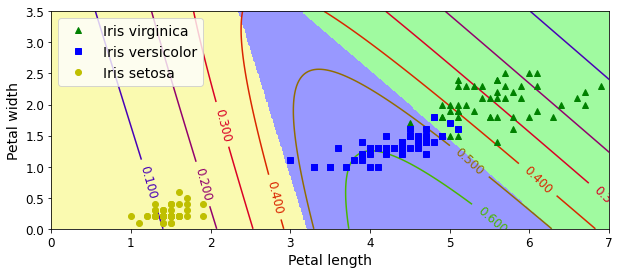

In [63]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [64]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333